In [1]:
import tensorflow as tf
import pandas as pd
import random
import numpy as np
import os
import matplotlib.pyplot as plt
import shutil
import seaborn as sns


from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report

from tensorflow.keras import models, layers
from tensorflow import keras
from tensorflow.keras.layers import Input, Lambda, Flatten, Reshape, Conv2D, MaxPooling2D, Dropout, Activation, BatchNormalization
from tensorflow.keras.layers import Dense, Concatenate, Add, Reshape, Dot, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, array_to_img, img_to_array

from tensorflow.keras.applications import InceptionV3, ResNet152V2, VGG16, VGG19, MobileNet
from keras.applications.densenet import DenseNet201
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

2024-03-20 00:05:10.241118: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-20 00:05:10.241209: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-20 00:05:10.372876: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS   = 3

In [ ]:
! pwd

In [3]:
#Loading the text file
df = pd.read_csv("/kaggle/input/Folds.csv")

In [4]:
#find duplicate rows across specific columns
duplicateRows = df[df.duplicated(['mag', 'grp', 'filename'])]

In [5]:
dataset = df.iloc[:7909, :]

In [6]:
dataset.loc[dataset['grp'] == 'test'].shape[0]

2904

In [7]:
dataset.shape[0]

7909

In [8]:
#Renaming the column filename to path
dataset = dataset.rename(columns = {"filename":"path"})
#Show first 5 entries
dataset.head()

fold  mag    grp                                               path
0     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...
1     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...
2     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...
3     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...
4     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...

In [9]:
#Creating new columns for the filename, file location and labels from the path column
dataset['filename'] = dataset['path'].apply(lambda x:x.split("/")[-1])
dataset["label"] = dataset['path'].apply(lambda x: x.split("/")[3])
dataset["sublabel"] = dataset['path'].apply(lambda x: x.split("/")[5])
dataset['file_loc'] = dataset['label'] + "_" + dataset['filename']

**Encoding the class to integer**

Setting benign to 0
Setting Malignant to 1

In [10]:
#Encoding the class to integer
dataset['class'] = dataset['label'].apply(lambda x: 0 if x =='benign' else 1)

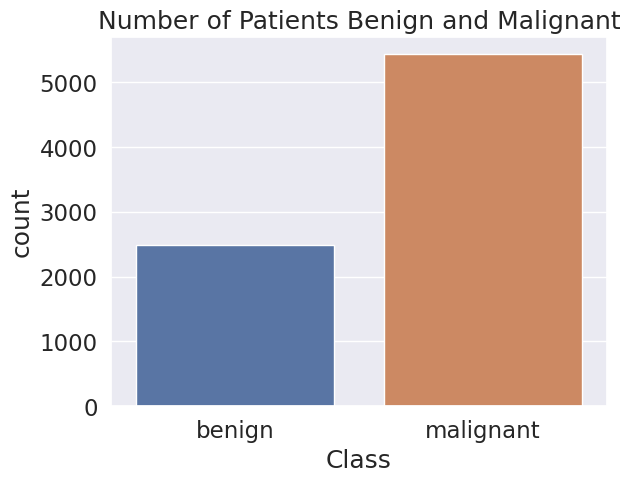

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'label' is a categorical column in your DataFrame
# If it's not, you might need to replace 'label' with the actual column name.
sns.set(font_scale=1.5)
sns.set_style("darkgrid")

# Assuming 'dataset' is your DataFrame
sns.countplot(data=dataset, x="label")
plt.xlabel("Class")
plt.title("Number of Patients Benign and Malignant")
plt.show()


In [12]:
print('Number of samples for each class: \n', dataset["class"].value_counts())

Number of samples for each class: 
 class
1    5429
0    2480
Name: count, dtype: int64


In [13]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7909 entries, 0 to 7908
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   fold      7909 non-null   int64 
 1   mag       7909 non-null   int64 
 2   grp       7909 non-null   object
 3   path      7909 non-null   object
 4   filename  7909 non-null   object
 5   label     7909 non-null   object
 6   sublabel  7909 non-null   object
 7   file_loc  7909 non-null   object
 8   class     7909 non-null   int64 
dtypes: int64(3), object(6)
memory usage: 556.2+ KB


In [14]:
dataset['mag'].unique()

array([100, 200,  40, 400])

In [15]:
dataset_mag = dict()
dataset_mag[40] = dataset.loc[dataset['filename'].str.contains('40')]
dataset_mag[100] = dataset.loc[dataset['filename'].str.contains('100')]
dataset_mag[200] = dataset.loc[dataset['filename'].str.contains('200')]
dataset_mag[400] = dataset.loc[dataset['filename'].str.contains('400')]

In [16]:
def count_dataset(datasets):
    i = 0
    fig, ax = plt.subplots(2, 2, figsize=(20, 16)) 
    for key, value in datasets.items():
        i += 1
        plt.subplot(2,2, i)
        sns.set(font_scale=1.5)
        sns.set_style("darkgrid")
        # Assuming 'dataset' is your DataFrame
        sns.countplot(data=value, x="label")
        plt.xlabel("Class")
        plt.title("Benign and Malignant with Magnitude X" + str(key))
    plt.show()

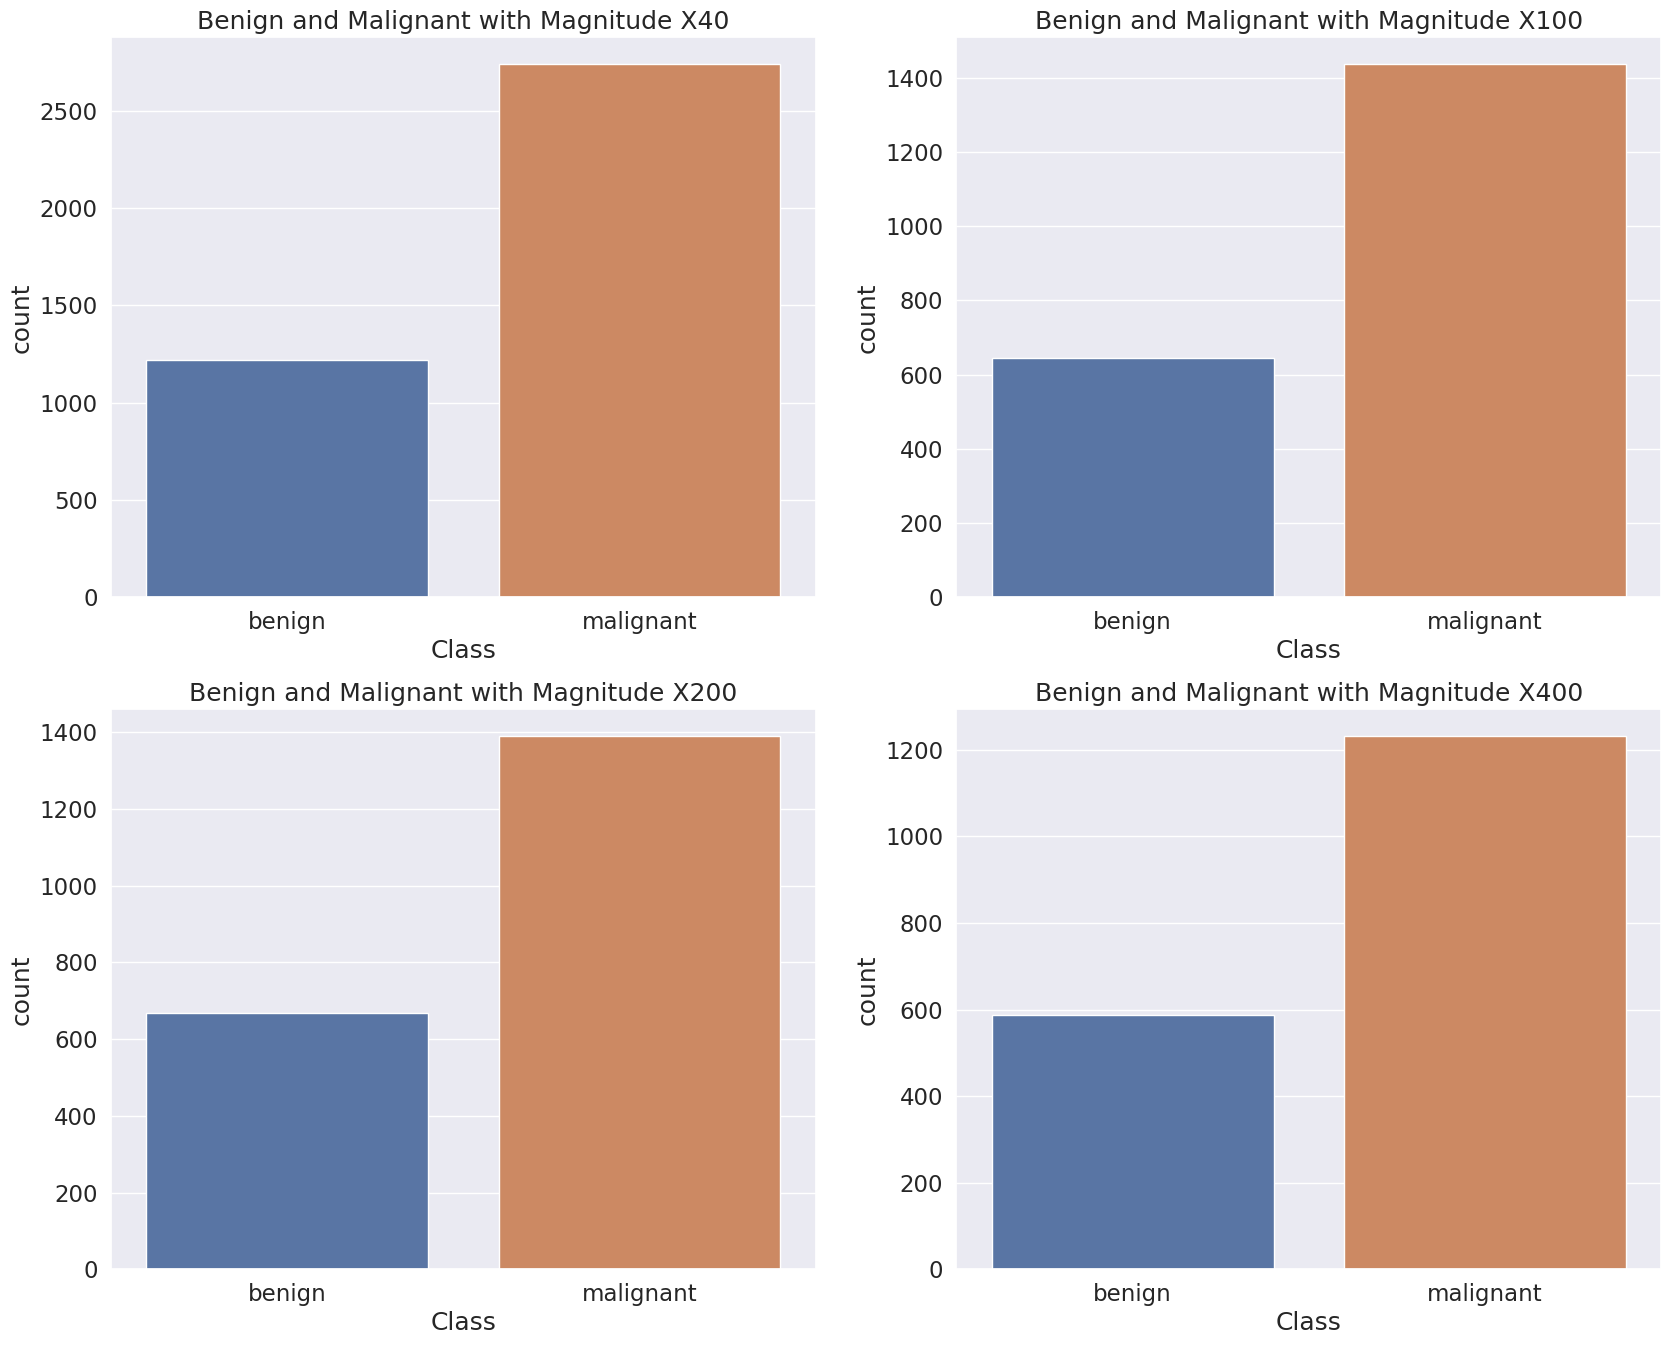

In [17]:
count_dataset(dataset_mag)

In [18]:
for key, value in dataset_mag.items():
    value_counts = value['label'].value_counts()
    print(f'The number patients of Benign and Malignant of Magnitude X{key}')
    print(value_counts)
    print(f'The ratio of balance data is: {round(value_counts.iloc[1] / value_counts.iloc[0], 2)}\n\n')

The number patients of Benign and Malignant of Magnitude X40
label
malignant    2741
benign       1217
Name: count, dtype: int64
The ratio of balance data is: 0.44


The number patients of Benign and Malignant of Magnitude X100
label
malignant    1437
benign        644
Name: count, dtype: int64
The ratio of balance data is: 0.45


The number patients of Benign and Malignant of Magnitude X200
label
malignant    1390
benign        667
Name: count, dtype: int64
The ratio of balance data is: 0.48


The number patients of Benign and Malignant of Magnitude X400
label
malignant    1232
benign        588
Name: count, dtype: int64
The ratio of balance data is: 0.48




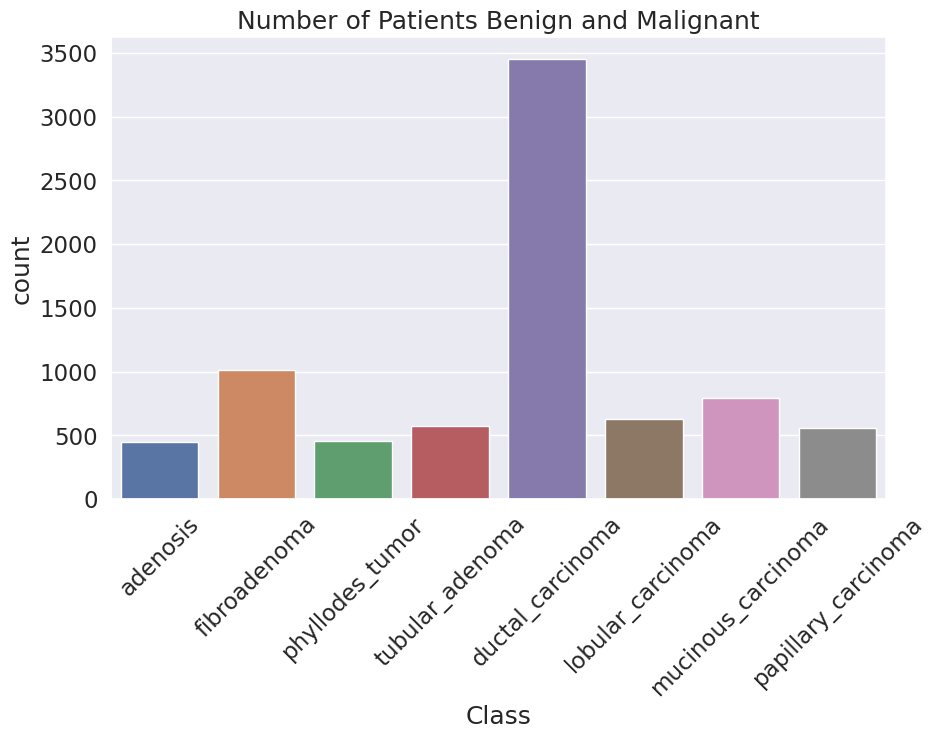

In [19]:
plt.figure(figsize=(10,6))
sns.set(font_scale=1.5)
sns.set_style("darkgrid")

# Assuming 'dataset' is your DataFrame
sns.countplot(data=dataset, x="sublabel")
plt.xlabel("Class")
plt.title("Number of Patients Benign and Malignant")
plt.xticks(rotation=45)
plt.show()

# Augumentation

In [20]:
dataset['sublabel'].value_counts()

sublabel
ductal_carcinoma       3451
fibroadenoma           1014
mucinous_carcinoma      792
lobular_carcinoma       626
tubular_adenoma         569
papillary_carcinoma     560
phyllodes_tumor         453
adenosis                444
Name: count, dtype: int64

In [21]:
sublabels = dataset['sublabel'].unique()

In [22]:
dataset_without_M_DC = dataset.loc[dataset['sublabel'] != 'ductal_carcinoma']

In [23]:
dataset_M_DC = dataset.loc[dataset['sublabel'] == 'ductal_carcinoma']

In [24]:
dataset_M_DC.shape

(3451, 9)

In [25]:
filter_data = list()
x100 = 0
x200=0
x400=0
x40=0

for index, row in dataset_M_DC.iterrows():
    filename = row['filename']
    if (filename.split('-')[3]=='40') and (x40<217):
        x40+=1
        filter_data.append(row)
    elif (filename.split('-')[3]=='200') and (x200<217):
        x200+=1
        filter_data.append(row)
    elif (filename.split('-')[3]=='100') and (x100<217):
        x100+=1
        filter_data.append(row)

    elif (filename.split('-')[3]=='400') and (x400<217):
        x400+=1
        filter_data.append(row)


In [26]:
new_dataset_M_DC = pd.DataFrame(filter_data)
new_dataset_M_DC.shape

(868, 9)

In [27]:
new_dataset = pd.concat([dataset_without_M_DC, new_dataset_M_DC], ignore_index=True)

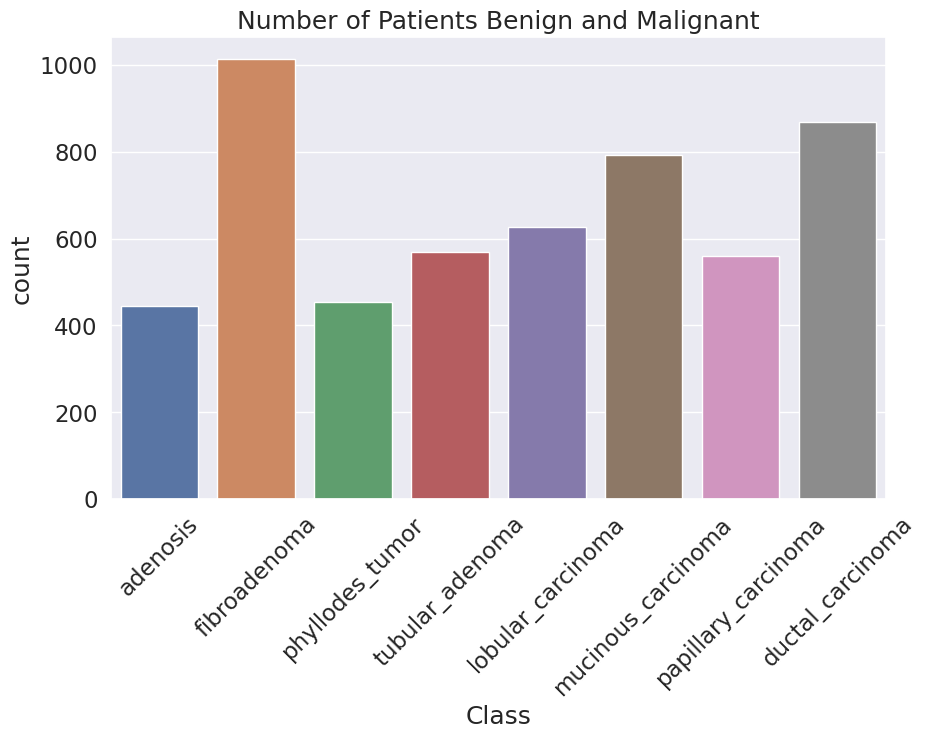

In [28]:
plt.figure(figsize=(10,6))
sns.set(font_scale=1.5)
sns.set_style("darkgrid")

# Assuming 'dataset' is your DataFrame
sns.countplot(data=new_dataset, x="sublabel")
plt.xlabel("Class")
plt.title("Number of Patients Benign and Malignant")
plt.xticks(rotation=45)
plt.show()

In [29]:
dataset = new_dataset

In [30]:
# ! rm /kaggle/working/Image_Dataset/ -R

In [31]:
# os.makedirs("/kaggle/working/Image_Dataset/")
# for label in sublabels:
#     label_path = "/kaggle/working/Image_Dataset/" + label
#     os.makedirs(label_path)

In [32]:
# #Moving all the images into one folder (Image_Dataset)
# i = 0
# for p in dataset['path']:
#     src = "/kaggle/input/BreaKHis_v1/" + p
#     dest = "/kaggle/working/Image_Dataset/" +  dataset["sublabel"][i]

#     #saving the files with its corresponding class and patient_id
#     dest = os.path.join(dest,src.split("/")[7]+ "_" + src.split("/")[-1])
# #     if src.split('/')[-2] == '400X':
# #         shutil.copyfile(src,dest)
# #         i +=1
#     shutil.copyfile(src,dest)
#     i +=1

# Data Preprogressing

In [33]:
#Creating new directory
os.makedirs("/kaggle/working/Image_Dataset/")
#Creating new directory for benign
os.makedirs("/kaggle/working/Image_Dataset/Benign/")
#Creating new directory for malignant
os.makedirs("/kaggle/working/Image_Dataset/Malignant/")

In [34]:
#Moving all the images into one folder (Image_Dataset)
i = 0
for p in dataset['path']:
    src = "/kaggle/input/BreaKHis_v1/" + p
    dest = "/kaggle/working/Image_Dataset/"
    if dataset["class"][i] == 0:
        dest = "/kaggle/working/Image_Dataset/Benign/"
    else:
        dest = "/kaggle/working/Image_Dataset/Malignant/"
    #saving the files with its corresponding class and patient_id
    dest = os.path.join(dest,src.split("/")[7]+ "_" + src.split("/")[-1])
#     if src.split('/')[-2] == '400X':
#         shutil.copyfile(src,dest)
#         i +=1
    shutil.copyfile(src,dest)
    i +=1

In [35]:
train_datagen = ImageDataGenerator(rescale = 1./255)

In [36]:
train_path = './Image_Dataset'
train_set = train_datagen.flow_from_directory(train_path,
                                              target_size = (IMAGE_SIZE,IMAGE_SIZE),
                                              batch_size = BATCH_SIZE,
                                              class_mode = 'categorical',
                                              shuffle=True)

Found 5326 images belonging to 2 classes.


In [37]:
from sklearn.model_selection import train_test_split

train_images, test_images, train_labels, test_labels = train_test_split(
    train_set.filenames,
    train_set.classes,
    test_size=0.2,
    random_state=42,
    stratify=train_set.classes
)

In [38]:
class My_Custom_Generator(keras.utils.Sequence):

  def __init__(self, image_filenames, labels, directory, batch_size):
    self.image_filenames = image_filenames
    self.labels = labels
    self.batch_size = batch_size
    self.directory = directory

  def __len__(self):
    return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(int)

  def __getitem__(self, idx):
    batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
    batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]
    data = np.array([
            image.img_to_array(image.load_img(os.path.join(self.directory, file_name), target_size=(256, 256)))
               for file_name in batch_x])/255.0

    return (data, np.array(batch_y))

  def generator(self):
    for idx in range(len(self)):
      yield self.__getitem__(idx)

  def get_dataset(self):
    output_signature = (
        tf.TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.int32)
    )

    return tf.data.Dataset.from_generator(
        self.__getitem__,
        output_signature=output_signature
    )

In [39]:
# my_train_batch_generator = My_Custom_Generator(train_images, train_labels, train_path, 32)
my_test_batch_generator = My_Custom_Generator(test_images, test_labels, train_path, 32)

In [40]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
inputs_shape = Input(shape=input_shape)

In [41]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4, restore_best_weights=True)

In [42]:
def eval_prioritization_strategy(prioritizer, x_train, y_train, epoch=12):
    train_indices = range(len(x_train))
    NUM_SAMPLE = round(len(x_train) * 0.05)
    print(NUM_SAMPLE)
    START_SAMPLE = round(len(x_train) * 0.1)
    test_accuracies = []
    x_train_subset = np.zeros([0,])
    y_train_subset = np.empty([0,])
    inception_model = ResNet152V2(
        weights="imagenet",
        input_tensor=inputs_shape,
        input_shape=(256, 256, 3),
        include_top=False
    )
    for layer in inception_model.layers[:140]:
        layer.trainable = False
    for i in range(epoch):
        if i == 0:
            selected_indices = train_indices[0:START_SAMPLE]
            train_indices = train_indices[START_SAMPLE:]
        else:
            selected_indices = train_indices[0:NUM_SAMPLE]
            train_indices = train_indices[NUM_SAMPLE:]
        x_train_subset = np.concatenate((x_train_subset, x_train[selected_indices,...]))
        y_train_subset = np.concatenate((y_train_subset, y_train[selected_indices,...]))
        my_train_batch_generator = My_Custom_Generator(x_train_subset, y_train_subset, train_path, 32)
        my_predict_batch_generator = My_Custom_Generator(x_train[train_indices,...], y_train[train_indices,...], train_path, 32)
        x3 = inception_model.output
        x3 = tf.keras.layers.GlobalAveragePooling2D()(x3)
        x3 = Dense(512, activation = "relu")(x3)
        x3 = tf.keras.layers.Dropout(0.2)(x3)
        x3 = tf.keras.layers.Dense(256, activation='relu')(x3)   # pass the merged tensor to the Dense layer, not the Concatenate layer output
        d1 = tf.keras.layers.Dropout(0.2)(x3)
        h2 = tf.keras.layers.Dense(128, activation = "relu")(x3)
        d2 = tf.keras.layers.Dropout(0.2)(h2)

        output = tf.keras.layers.Dense(1, activation='sigmoid')(d2)

        model = tf.keras.Model(inputs=inputs_shape, outputs=output)

        model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

        model.fit(my_train_batch_generator, epochs=20, verbose=0, callbacks=[early_stopping])
        loss, accuracy = model.evaluate(my_test_batch_generator, verbose=1)
        test_accuracies.append(accuracy)
        print('Training data size of %d => accuracy %f' % (x_train_subset.shape[0], accuracy))

        predictions = model.predict(my_predict_batch_generator)
        train_indices = prioritizer(train_indices, predictions)

    return test_accuracies


In [43]:
def margin_prioritizer(indices, predictions):
    predictions = np.array([[abs(item[0] - 0.5) + 0.5, 1 - (abs(item[0] - 0.5) + 0.5)] if item[0] <= 0.5 else [1 - (abs(item[0] - 0.5) + 0.5), abs(item[0] - 0.5) + 0.5] for item in predictions])
    p = -np.sort(-predictions) # sort in descending order
    p = p[:,0] - p[:,1]
    p = list(zip(indices, p))
    p.sort(key=lambda x : x[1]) # sort in ascending order
    return list(zip(*p))[0]

In [44]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [46]:
accuracy = eval_prioritization_strategy(margin_prioritizer, train_images, train_labels)

213
234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1710893366.828769     122 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1710893367.017554     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


 2/34 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.6953 - loss: 562.7814

W0000 00:00:1710893577.909157     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 475ms/step - accuracy: 0.5305 - loss: 1068.1335
Training data size of 426 => accuracy 0.485929
  2/120 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step 

W0000 00:00:1710893603.468986     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


120/120 ━━━━━━━━━━━━━━━━━━━━ 67s 485ms/step


W0000 00:00:1710893784.994809     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 2/34 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.8047 - loss: 2.8636

W0000 00:00:1710894067.563763     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 476ms/step - accuracy: 0.8239 - loss: 2.0469
Training data size of 639 => accuracy 0.836773
  2/114 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step  

W0000 00:00:1710894093.908074     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


114/114 ━━━━━━━━━━━━━━━━━━━━ 62s 462ms/step


W0000 00:00:1710894270.798679     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 2/34 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.8047 - loss: 4.4122

W0000 00:00:1710894584.646723     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 477ms/step - accuracy: 0.8676 - loss: 2.4490
Training data size of 852 => accuracy 0.878987
  2/107 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step 

W0000 00:00:1710894630.401586     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


107/107 ━━━━━━━━━━━━━━━━━━━━ 60s 476ms/step


W0000 00:00:1710894806.445381     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 2/34 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.7891 - loss: 2.9846

W0000 00:00:1710895168.487808     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


34/34 ━━━━━━━━━━━━━━━━━━━━ 26s 484ms/step - accuracy: 0.8623 - loss: 2.1583
Training data size of 1065 => accuracy 0.884615
  2/100 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step 

W0000 00:00:1710895194.320221     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


100/100 ━━━━━━━━━━━━━━━━━━━━ 60s 506ms/step


W0000 00:00:1710895372.993708     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 2/34 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.8438 - loss: 2.3891

W0000 00:00:1710895810.677273     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 476ms/step - accuracy: 0.8808 - loss: 2.0281
Training data size of 1278 => accuracy 0.900563
 2/94 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step 

W0000 00:00:1710895856.454278     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 56s 499ms/step


W0000 00:00:1710896036.953348     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 2/34 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.8281 - loss: 2.4803

W0000 00:00:1710896505.936261     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


34/34 ━━━━━━━━━━━━━━━━━━━━ 26s 492ms/step - accuracy: 0.8903 - loss: 1.2917
Training data size of 1491 => accuracy 0.902439
 2/87 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step  

W0000 00:00:1710896532.975377     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


87/87 ━━━━━━━━━━━━━━━━━━━━ 56s 529ms/step


W0000 00:00:1710896705.900571     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 2/34 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.8906 - loss: 2.1559

W0000 00:00:1710897216.769328     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


34/34 ━━━━━━━━━━━━━━━━━━━━ 28s 512ms/step - accuracy: 0.8946 - loss: 1.1627
Training data size of 1704 => accuracy 0.903377
 2/80 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step  

W0000 00:00:1710897243.927580     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


80/80 ━━━━━━━━━━━━━━━━━━━━ 54s 557ms/step


W0000 00:00:1710897416.745807     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 2/34 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.9141 - loss: 1.0484

W0000 00:00:1710898000.587222     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 478ms/step - accuracy: 0.9197 - loss: 0.8617
Training data size of 1917 => accuracy 0.921201
 2/74 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step 

W0000 00:00:1710898026.117246     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


74/74 ━━━━━━━━━━━━━━━━━━━━ 47s 521ms/step


W0000 00:00:1710898192.614481     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 2/34 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.8906 - loss: 1.5166

W0000 00:00:1710898809.711261     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 481ms/step - accuracy: 0.9160 - loss: 1.1034
Training data size of 2130 => accuracy 0.918387
 2/67 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step 

W0000 00:00:1710898835.280798     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


67/67 ━━━━━━━━━━━━━━━━━━━━ 42s 496ms/step


W0000 00:00:1710898997.862739     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 2/34 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 0.9297 - loss: 1.3812

W0000 00:00:1710899656.523031     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


34/34 ━━━━━━━━━━━━━━━━━━━━ 26s 477ms/step - accuracy: 0.9194 - loss: 0.9801
Training data size of 2343 => accuracy 0.923077
 2/60 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step

W0000 00:00:1710899681.818328     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


60/60 ━━━━━━━━━━━━━━━━━━━━ 40s 520ms/step


W0000 00:00:1710899846.497570     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 2/34 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 0.9062 - loss: 2.3587

W0000 00:00:1710900583.709771     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


34/34 ━━━━━━━━━━━━━━━━━━━━ 29s 596ms/step - accuracy: 0.9198 - loss: 1.3681
Training data size of 2556 => accuracy 0.925891
 2/54 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step 

W0000 00:00:1710900613.553455     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


54/54 ━━━━━━━━━━━━━━━━━━━━ 47s 712ms/step


W0000 00:00:1710900785.745371     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 2/34 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 0.8906 - loss: 0.6907

W0000 00:00:1710901916.680063     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


34/34 ━━━━━━━━━━━━━━━━━━━━ 35s 686ms/step - accuracy: 0.9128 - loss: 0.4827
Training data size of 2769 => accuracy 0.924953
 2/47 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step 

W0000 00:00:1710901949.929156     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


47/47 ━━━━━━━━━━━━━━━━━━━━ 45s 761ms/step


In [47]:
accuracies = dict()
accuracies['Margin'] = accuracy

In [48]:
file_path = 'data.csv'
if os.path.exists(file_path):
    df_result = pd.read_csv(file_path)
    df_result['Margin'] = prioritized_accuracies
    df_result.to_csv(file_path, mode='w', index=False)
else:
    df_result = pd.DataFrame.from_dict(accuracies)
    df_result.to_csv(file_path, mode='x',  index=False)